In [1]:
import os
os.chdir("/home/149/ab8992/tasman-tides")
import argparse
import ttidelib as tt
# import os
import subprocess
import time
from dask.distributed import Client,default_client
from matplotlib import pyplot as plt
from pathlib import Path
home = Path("/home/149/ab8992/tasman-tides")
gdata = Path("/g/data/nm03/ab8992")
import xarray as xr


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()

def surface_speed_movie(experiment):
    """
    Make a movie of the ekman pumping
    """
    startdask()

    tau = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/{experiment}/**/surface.nc",decode_times=False,chunks = {"time":1})[["taux","tauy"]]
    # interpolate the xq and yq onto xh and yh using xarray built in method
    tau = tau.interp(xq = tau.xh,yq = tau.yh)
    bathy = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/{experiment}/topog_raw.nc",decode_times = False).elevation
    bathy = bathy.rename({"lat":"yh","lon":"xh"})
    bathy = bathy.where(bathy > 0).persist()

    curl = tau.tauy.differentiate("xh") - tau.taux.differentiate("yh")

    data = xr.Dataset(
        {
            "curl":curl,
            "bathy":bathy
        }
    )


    print("Start making movie...")
    tt.make_movie(data,
                tt.plot_surfacespeed,
                experiment,
                "ekman_pumping",
                framerate=5,
                parallel=False)

    return



def vorticity_movie(experiment, outputs):
    """
    Make a movie of the vorticity for the given experiment and outputs
    """
    startdask()

    data = tt.collect_data(experiment,ppdata=["vorticity_surface","vorticity_transect"],chunks = {"time":1},outputs=outputs,bathy=True)
    print("loaded data")
    print(data)
    fig = plt.figure(figsize=(20, 12))

    print("Start making movie...")
    tt.make_movie(data,
                tt.plot_vorticity,
                experiment,
                "surface_speed",
                framerate=5,
                parallel=True)

    return

def save_ppdata(transect_data,topdown_data,basepath,recompute = False):
    """
    Save the postprocessed data to gdata. Takes computed topdown and transect data and saves each time slice to postprocessed folders
    Time index override is used when processing one time slice at a time. That way the index can be used to name the file correctly
    """
    print(basepath)
    print(basepath.name)
    print(str(type(basepath.name)))
    for i in ["topdown","transect"]:
        if not os.path.exists(basepath / i):
            os.makedirs(basepath / i)

    for i in range(len(topdown_data.time.values)):
        time = topdown_data.time.values[i]
        if not os.path.exists(basepath / "topdown" / f"vorticity_time-{str(i).zfill(3)}.nc") or recompute:
            topdown_data.isel(time = i).expand_dims("time").assign_coords(time = [time]).to_netcdf(basepath / "topdown" / str(basepath.name + f"_time-{str(round(time))}.nc"))

        if not os.path.exists(basepath / "transect" / f"vorticity_time-{str(i).zfill(3)}.nc") or recompute:
            transect_data.isel(time = i).expand_dims("time").assign_coords(time = [time]).to_netcdf(basepath / "transect" / str(basepath.name + f"_time-{str(round(time))}.nc"))


    return

def save_vorticity(experiment,outputs,recompute = False):
    """
    Save the relative vorticity for the given experiment and outputs
    """
    basepath = gdata / "postprocessed" / experiment / "vorticity"
    startdask()


    rawdata = tt.collect_data(
        experiment,
        outputs=outputs,
        rawdata = ["u","v"],
        chunks = {"time": -1,"xb":-1,"zl":10}
        )

    vorticity_topdown = tt.calculate_vorticity(rawdata).coarsen(time = 149,boundary = "trim").mean().drop("lat").drop("lon").rename("vorticity").isel(zl = 2)
    vorticity_transect = tt.calculate_vorticity(rawdata).coarsen(time = 149,boundary = "trim").mean().drop("lat").drop("lon").rename("vorticity").sel(yb = 0,method = "nearest")

    save_ppdata(vorticity_transect,vorticity_topdown,basepath,recompute=recompute)

    return 

def save_filtered_vels(experiment,outputs,recompute = False):
    """
    Calculate the filtered velocities over 149 hours and save u'u', v'v', u'v' all averaged over 149 hours as separate files
    """
    startdask()

    m2 = 360 / 28.984104 ## Period of m2 in hours
    averaging_window = int(12 * m2) ## this comes out to be 149.0472 hours, so close enough to a multiple of tidal periods
    m2f = 1/ m2    ## Frequency of m2 in radians per hour

    data = tt.collect_data(
        experiment,
        outputs=outputs,
        rawdata = ["u","v","ahh"],
        bathy=False,
        chunks = {"time": -1,"xb":-1,"zl":10}
        )
    for i in range(0,len(data.time) // averaging_window):
        mid_time =  data.time[round((i + 0.5) * averaging_window) ] ## Middle of time window time

        print("Processing time slice",f"{i} = {mid_time}")
        u_ = data.u.isel(
                time = slice(i * averaging_window, (i + 1) * averaging_window)
                ).chunk({"time":-1}).drop(["lat","lon"]).fillna(0)
        v_ = data.v.isel(
                time = slice(i * averaging_window, (i + 1) * averaging_window)
                ).chunk({"time":-1}).drop(["lat","lon"]).fillna(0)
        ahh = data.ahh.isel(
                time = slice(i * averaging_window, (i + 1) * averaging_window)
                ).chunk({"time":-1}).drop(["lat","lon"]).fillna(0)
        U = tt.m2filter(
            u_,
            m2f).persist()
        V = tt.m2filter(
            v_,
            m2f).persist()
        
        # Calculate dissipation as viscosity * laplacian(u)^2 
        laplacian2 = (U.differentiate("xb").differentiate("xb") + V.differentiate("yb").differentiate("yb")
                )**2
        dissipation = (laplacian2.mean("time") * ahh.mean("time")).expand_dims("time").assign_coords(time = [mid_time]).rename("velocity_laplacian")

        data_to_save = {
            "UU" : (U * U).mean("time").expand_dims("time").assign_coords(time = [mid_time]).rename("UU"),
            "VV" : (V * V).mean("time").expand_dims("time").assign_coords(time = [mid_time]).rename("VV"),
            "UV" : (U * V).mean("time").expand_dims("time").assign_coords(time = [mid_time]).rename("UV"),
            "dissipation" : dissipation
        }

        for key in data_to_save:
            if key == "dissipation":
                basepath = gdata / "postprocessed" / experiment / key
                save_ppdata(
                    data_to_save[key].sel(yb = 0,method = "nearest"),
                    data_to_save[key].integrate("zl"),
                    basepath,
                    recompute=recompute
                )

    return 


def qsub(recipe, experiment, outputs):
    tt.logmsg(f"Submitting {recipe} for {experiment}, {outputs} to qsub")
    if not os.path.exists(f"/home/149/ab8992/tasman-tides/logs/{recipe}"):
        os.makedirs(f"/home/149/ab8992/tasman-tides/logs/{recipe}")
    text = f"""
#!/bin/bash
#PBS -N {recipe}-{experiment}
#PBS -P v45
#PBS -q normalbw
#PBS -l mem=112gb
#PBS -l walltime=6:00:00
#PBS -l ncpus=28
#PBS -l jobfs=2gb
#PBS -l storage=gdata/v45+scratch/v45+scratch/x77+gdata/v45+gdata/nm03+gdata/hh5
PYTHONNOUSERSITE=1
module use /g/data/hh5/public/modules
module load conda/analysis3-unstable
module list
python3 /home/149/ab8992/tasman-tides/recipes.py -r {recipe} -e {experiment} -o {outputs} -q 0"""

    with open(f"/home/149/ab8992/tasman-tides/logs/{recipe}/{recipe}-{experiment}.pbs", "w") as f:
        f.write(text)

    result = subprocess.run(
        f"qsub /home/149/ab8992/tasman-tides/logs/{recipe}/{recipe}-{experiment}.pbs",
        shell=True,
        capture_output=True,
        text=True,
        cwd = f"/home/149/ab8992/tasman-tides/logs/{recipe}",
    )
    pbs_error = f"{recipe}-{experiment}.e{result.stdout.split('.')[0]}"
    pbs_log = f"{recipe}-{experiment}.o{result.stdout.split('.')[0]}"

    # Wait until the PBS logfile appears in the log folder
    while not os.path.exists(f"/home/149/ab8992/tasman-tides/logs/{recipe}/{pbs_error}"):
        time.sleep(10)

    ## Rename the logfile to be recipe--experiment--current_date
    current_date = time.strftime("%b_%d_%H-%M-%S").lower()
    os.rename(
        f"/home/149/ab8992/tasman-tides/logs/{recipe}/{pbs_error}",
        f"/home/149/ab8992/tasman-tides/logs/{recipe}/{experiment}_{current_date}.err",
    )
    os.rename(
        f"/home/149/ab8992/tasman-tides/logs/{recipe}/{pbs_log}",
        f"/home/149/ab8992/tasman-tides/logs/{recipe}/{experiment}_{current_date}.out",
    )

    return
    
        


In [33]:
tau = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/full-80/**/surface.nc",decode_times=False)[["taux","tauy"]]
import matplotlib
# interpolate the xq and yq onto xh and yh using xarray built in method
tau = tau.interp(xq = tau.xh,yq = tau.yh)

curl = tau.tauy.differentiate("xh") - tau.taux.differentiate("yh")
curl = curl.isel(time = 140).persist()


In [32]:
earth_cmap = matplotlib.cm.get_cmap("gist_earth")

bathy = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/full-80/topog_raw.nc",decode_times = False).elevation
bathy = bathy.rename({"lat":"yh","lon":"xh"})
bathy = bathy.where(bathy > 0).persist()
# bathy.where(bathy > 0).plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax,add_colorbar = False)

/jobfs/107261640.gadi-pbs/ipykernel_3482095/639982054.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")


Text(0, 0.5, 'Latitude')

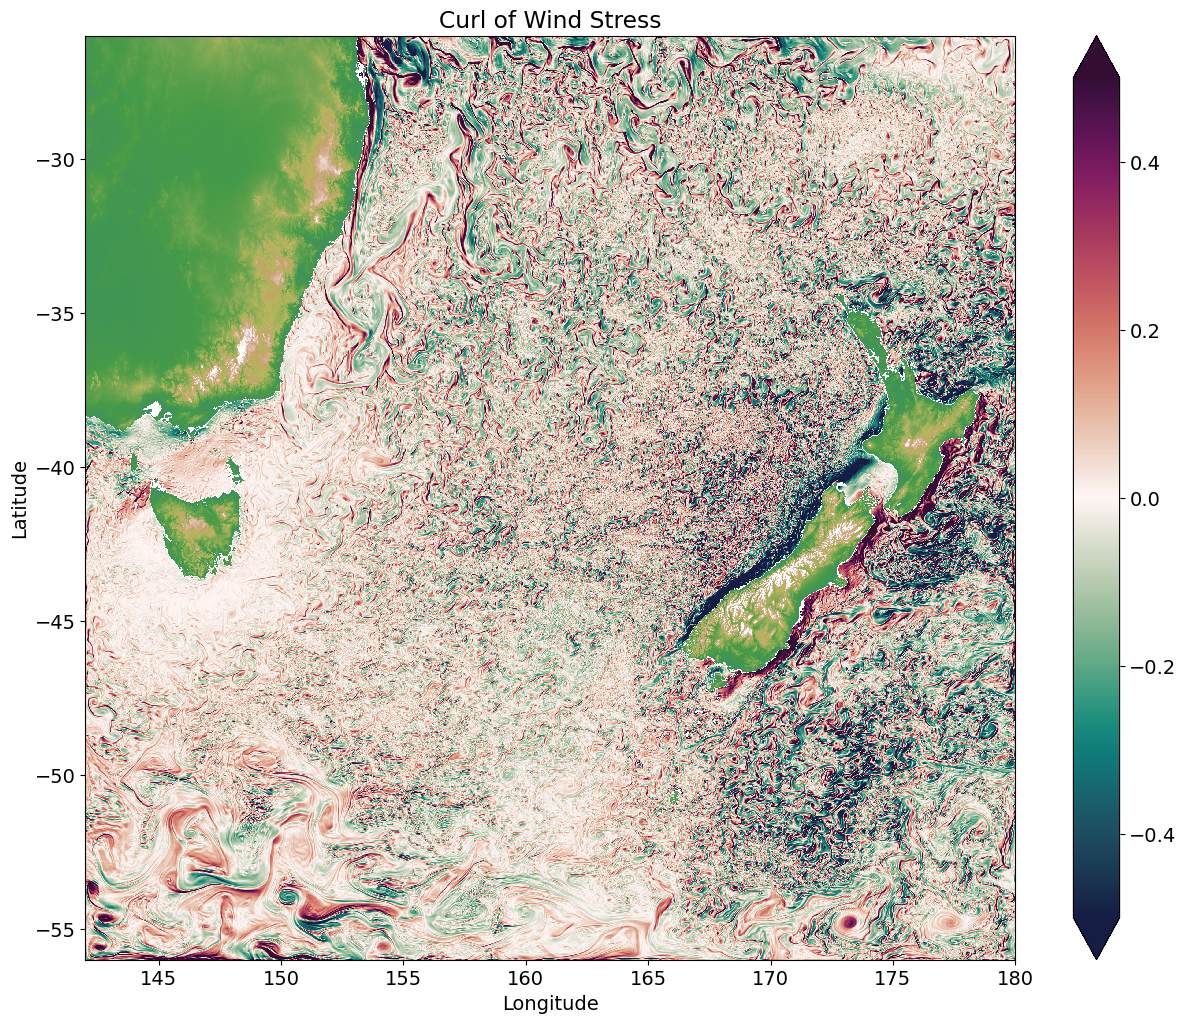

In [34]:
%matplotlib inline
import cmocean
cmap = cmocean.cm.curl
fig,ax = plt.subplots(1,figsize = (15,12))
curl.plot(vmax = 0.5,vmin = - 0.5,ax = ax,cmap = cmap)
bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax,add_colorbar = False)
ax.set_title("Curl of Wind Stress")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [2]:
import matplotlib
import cmocean
cmap = cmocean.cm.curl
earth_cmap = matplotlib.cm.get_cmap("gist_earth")

def plot_ekman_pumping(data):
    """
    Plot the ekman pumping for the given data
    """
    fig,ax = plt.subplots(1,figsize = (15,12))
    
    data["curl"].plot(vmax = 0.5,vmin = - 0.5,ax = ax,cmap = cmap,add_colorbar = False)
    data["bathy"].plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax,add_colorbar = False)
    ax.set_title("Curl of Wind Stress")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    return fig

def ekman_pumping_movie(experiment):
    """
    Make a movie of the ekman pumping
    """
    resolution = experiment.split("-")[-1]
    startdask()

    tau = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/{experiment}/**/surface.nc",decode_times=False,chunks = {"time":1})[["taux","tauy"]]
    # interpolate the xq and yq onto xh and yh using xarray built in method
    tau = tau.interp(xq = tau.xh,yq = tau.yh)
    bathy = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/full-{resolution}/topog_raw.nc",decode_times = False).elevation
    bathy = bathy.rename({"lat":"yh","lon":"xh"})
    bathy = bathy.where(bathy > 0).persist()

    curl = tau.tauy.differentiate("xh") - tau.taux.differentiate("yh")

    data = xr.Dataset(
        {
            "curl":curl,
            "bathy":bathy
        }
    )


    print("Start making movie...")
    tt.make_movie(data,
                plot_ekman_pumping,
                experiment,
                "ekman_pumping",
                framerate=5,
                parallel=False)

    return

ekman_pumping_movie("full-80")

/jobfs/107269119.gadi-pbs/ipykernel_2804312/2897455433.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")


0.3.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Start making movie...
client:  <Client: 'tcp://127.0.0.1:44325' processes=7 threads=28, memory=112.00 GiB>
Making movie ekman_pumping for full-80
/g/data/v45/ab8992/movies_tmp/tasman-tides/full-80/movies/ekman_pumping


2024-01-30 12:27:51,189 - tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x145be83e44c0>, <Task finished name='Task-8887' coro=<BaseTCPListener._handle_stream() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py:655> exception=MemoryError((8245940487028229447,), dtype('uint8'))>)
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/ioloop.py", line 738, in _run_callback
    ret = callback()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/tornado/tcpserver.py", line 387, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py", line 667, in _handle_stream
    await self.on_connecti

ffmpeg -r 5  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/full-80/movies/ekman_pumping/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/full-80/moviesekman_pumping.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-n

/jobfs/107278537.gadi-pbs/ipykernel_3779602/3516328986.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


/jobfs/107278537.gadi-pbs/ipykernel_3779602/3516328986.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")


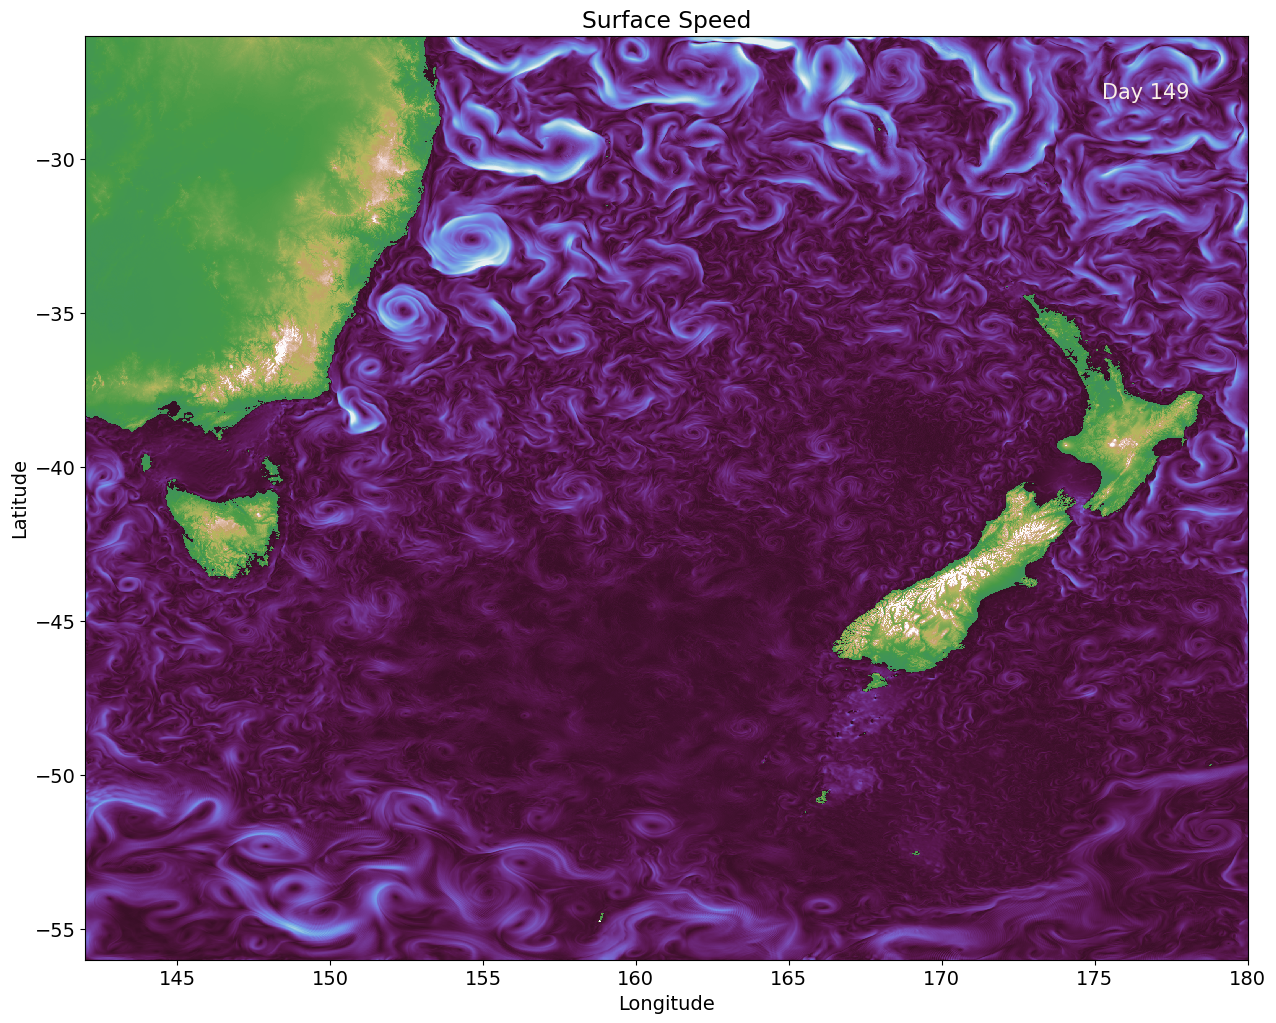

In [31]:
import matplotlib
import cmocean
earth_cmap = matplotlib.cm.get_cmap("gist_earth")

def plot_surfacespeed(data,**kwargs):

    cmap = cmocean.cm.dense_r
    earth_cmap = matplotlib.cm.get_cmap("gist_earth")
    fig,ax = plt.subplots(1,figsize = (15,12))
    # Set the background colour to the plot to the lowest value in the cmap
    ax.set_facecolor(cmap(0))
    
    data["speed"].plot(vmax = 4,vmin = 0,ax = ax,cmap = cmap,add_colorbar = False)
    data["bathy"].plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax,add_colorbar = False)
    ax.set_title("Surface Speed")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.text(0.95, 0.95, f"Day {int(data.time.values//24)}", transform=ax.transAxes, fontsize=15, va="top", ha="right",color = "linen")
    return fig

def surface_speed_movie(experiment):
    """
    Make a movie of the surface speed
    """
    resolution = experiment.split("-")[-1]
    startdask()



    speed = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/{experiment}/**/surface.nc",decode_times=False,chunks = {"time":1}).speed
    # interpolate the xq and yq onto xh and yh using xarray built in method
    bathy = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/full-{resolution}/topog_raw.nc",decode_times = False).elevation
    bathy = bathy.rename({"lat":"yh","lon":"xh"})
    bathy = bathy.where(bathy > 5).persist()


    data = xr.Dataset(
        {
            "speed":speed,
            "bathy":bathy
        }
    )


    print("Start making movie...")
    tt.make_movie(data,
                tt.plot_surfacespeed,
                experiment,
                "surface_speed",
                framerate=10,
                parallel=False)

    return

experiment = "full-80"

resolution = experiment.split("-")[-1]
startdask()

speed = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/{experiment}/**/surface.nc",decode_times=False,chunks = {"time":1}).speed
# interpolate the xq and yq onto xh and yh using xarray built in method
bathy = xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/full-{resolution}/topog_raw.nc",decode_times = False).elevation
bathy = bathy.rename({"lat":"yh","lon":"xh"})
bathy = bathy.where(bathy > 0).persist()
data = xr.Dataset(
    {
        "speed":speed,
        "bathy":bathy
    }
)

fig = plot_surfacespeed(data.isel(time = -1))

In [32]:
for i in range(10):
    if i > 5:
        continue
    print(i)

0
1
2
3
4
5


In [23]:
experiment = "full-20"
basepath = gdata / "postprocessed" / experiment
var = "UU"
import numpy as np
m2 = 360 / 28.984104 ## Period of m2 in hours
averaging_window = int(12 * m2) ## this comes out to be 149.0472 hours, so close enough to a multiple of tidal periods
m2f = 1/ m2    ## Frequency of m2 in radians per hour

data = tt.collect_data(
    experiment,
    outputs="output000",
    rawdata = ["u"],
    bathy=False,
    chunks = {"time": -1,"xb":-1,"zl":10}
)
    
for i in range(0,len(data.time) // averaging_window):
    time = data.time.values[i]
    mid_time =  data.time[int(np.floor((i + 0.5) * averaging_window)) ] ## Middle of time window time

        ## Here skip the time slice if it already exists and recompute is False
    print(int(mid_time.values),basepath / var / "topdown" / f"{var}_time-{int(mid_time.values)}.nc",os.path.exists(basepath / var / "topdown" / f"{var}_time-{int(mid_time.values)}.nc"))

75 /g/data/nm03/ab8992/postprocessed/full-20/UU/topdown/UU_time-75.nc True
224 /g/data/nm03/ab8992/postprocessed/full-20/UU/topdown/UU_time-224.nc True


In [22]:
os.path.exists("/g/data/nm03/ab8992/postprocessed/full-20/UU/topdown/UU_time-224.nc")

True